<a href="https://colab.research.google.com/github/RahilRehan/Covid19-detection/blob/master/covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [32]:
from google.colab import drive
drive.mount("/gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [33]:
import cv2
import numpy as np
import os
import copy
from PIL import Image

from imutils import paths
import cv2

print("[INFO] loading images...")
imagePaths = list(paths.list_images("/gdrive/My Drive/Colab Notebooks/dataset"))

for imagePath in imagePaths:
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  cv2.imwrite(imagePath, image)

[INFO] loading images...


In [34]:
data_dir = '/gdrive/My Drive/Colab Notebooks/dataset'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224,224)),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])
    test_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=4)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['covid', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shapes of data:  torch.Size([8, 3, 224, 224]) torch.Size([8])
tensor([1, 0, 0, 0, 0])


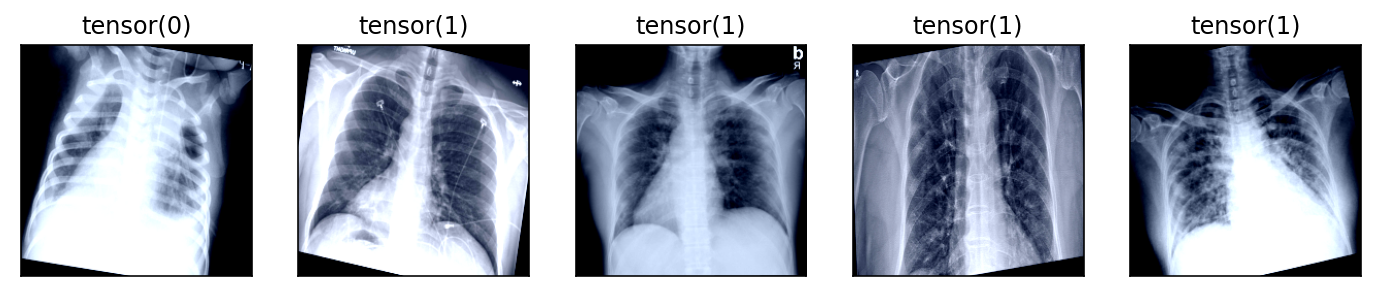

In [35]:
#Let us have look at the data and make sense of it
images, labels = next(iter(trainloader))
print("Shapes of data: ", images.shape, labels.shape)

print(labels[:5])
#Note that the labels has numbers rather than names, this makes our classification easier but we cannot interpret whats inside the image

#let us view some images

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

images,labels = images[0:5], labels[0:5]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(labels[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [37]:
vgg_based = models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
   param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
features = list(vgg_based.classifier.children())[:-1] # Remove last layer
features.extend([torch.nn.Linear(number_features, 2)])
vgg_based.classifier = torch.nn.Sequential(*features)

vgg_based = vgg_based.to(device)

print(vgg_based)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(vgg_based.parameters(), lr=0.003)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [0]:
import time
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       # model.train()

       train_loss = 0

       # Iterate over data.
       for i, data in enumerate(trainloader):
           inputs , labels = data
           inputs = inputs.to(device)
           labels = labels.to(device)

           optimizer.zero_grad()
          
           with torch.set_grad_enabled(True):
               outputs  = model(inputs)
               loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           train_loss += loss.item() * inputs.size(0)

           print('{} Loss: {:.4f}'.format(
               'train', train_loss / len(trainloader)))
          
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

In [0]:
def visualize_model(model, num_images=6):
   was_training = model.training
   model.eval()
   images_so_far = 0
   fig = plt.figure()

   with torch.no_grad():
       for i, (inputs, labels) in enumerate(testloader):
           inputs = inputs.to(device)
           labels = labels.to(device)

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)

           for j in range(inputs.size()[0]):
               images_so_far += 1
               ax = plt.subplot(num_images//2, 2, images_so_far)
               ax.axis('off')
               ax.set_title('predicted: {} truth: {}'.format(labels[preds[j]], labels[labels[j]]))
               img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
               img =  img/2 + 0.5
               ax.imshow(img)

               if images_so_far == num_images:
                   model.train(mode=was_training)
                   return
       model.train(mode=was_training)

In [50]:
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0010
train Loss: 0.6450
train Loss: 0.6546
train Loss: 0.6680
train Loss: 0.6700
Epoch 1/29
----------
train Loss: 0.0007
train Loss: 0.0016
train Loss: 0.0063
train Loss: 0.0063
train Loss: 0.0082
Epoch 2/29
----------
train Loss: 0.0001
train Loss: 0.2371
train Loss: 0.2647
train Loss: 0.2768
train Loss: 0.3691
Epoch 3/29
----------
train Loss: 0.1704
train Loss: 0.1704
train Loss: 0.1740
train Loss: 0.2084
train Loss: 1.1629
Epoch 4/29
----------
train Loss: 0.0082
train Loss: 0.0082
train Loss: 0.2119
train Loss: 0.2135
train Loss: 0.2179
Epoch 5/29
----------
train Loss: 0.0008
train Loss: 0.2524
train Loss: 0.2680
train Loss: 0.2680
train Loss: 0.2692
Epoch 6/29
----------
train Loss: 0.3381
train Loss: 0.3382
train Loss: 0.3384
train Loss: 0.3455
train Loss: 0.3634
Epoch 7/29
----------
train Loss: 0.0010
train Loss: 0.0011
train Loss: 0.0065
train Loss: 0.4774
train Loss: 0.4775
Epoch 8/29
----------
train Loss: 0.0001
train Loss: 0.0003
trai

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


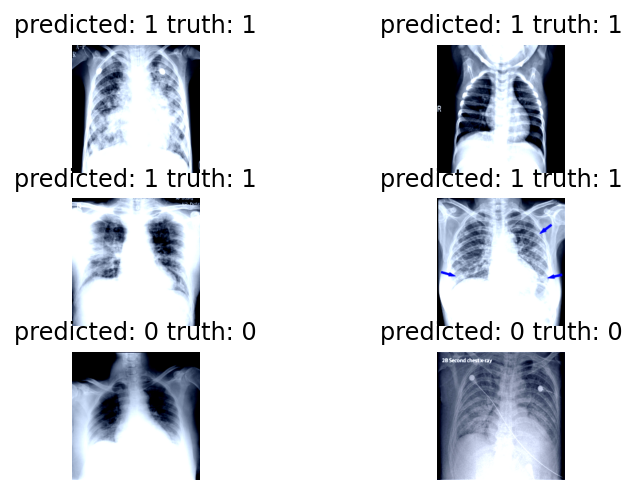

In [64]:
visualize_model(vgg_based)
plt.show()